# Political Polarization in FOX News and MSNBC

This iPython notebook provides the entry point and interface to the project. 

Check out `docs/` folder for a project presentation as well as a summary. 

The following features are provided in this notebook:
- Load the trained models via `models_dict = models.main(from_pickle=True)`
- `models_dict` is a dictionary of dictionaries that contains 
    * the LDA topic models for FOX New, MSNBC, and the combined corpus of transcripts
    * A Latent Semantic Indexing (LSI) model for the combined corpus
- A query using LSI is demonstrated 
- LDA topics are plotted using pyLDAvis

In [1]:
!ls

__init__.py    client.ipynb   models.py      processtext.py
__pycache__    data           pickles        scraper.py


### Standard module imports:

In [11]:
from collections import defaultdict
import importlib
import re

import numpy as np
import pandas as pd
import pickle

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context(context='talk')

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)


2018-06-04 15:27:46,581 : DEBUG : backend module://ipykernel.pylab.backend_inline version unknown


### Project imports:

In [3]:
#import scraper
import processtext 
import models


/Users/timcodes/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
2018-06-04 15:25:27,203 : INFO : 'pattern' package not found; tag filters are not available for English


** Load Data and Run LDA and LSI: **

All models can be loaded from pickle using `models.main()`. To run models anew, run `models.main(from_pickle=False)`.

In [13]:
importlib.reload(models)

models_dict, doc2network = models.main(from_pickle=True)

models_dict.keys()

dict_keys(['MSNBC', 'FOX', 'combined'])

## Create Latent Dirichlet Allocation & Latent Semantic Index models

Features:
- Tokenize and lemmatize
- Analyze word frequency and exclude rare terms
- Include bigrams to group common co-occurring terms, like "mueller" and "investigation"
- Create separate id2word dictionaries and corpora for Fox, MSNBC, and combined. 
- Create separate LDA and LSI models

In [5]:
# Functions for using the Latent Semantic Index models to create queries:

def search_corpus(query, models_dict, doc2network, top_x=10):
    """
    
    Expects a list of strings.
    """
    
    ref = models_dict['combined']
    
    vec_bow = ref['id2word'].doc2bow(query)
    vec_lsi = ref['lsi'][vec_bow] # convert the query to LSI space
    sims = models_dict['combined']['index'][vec_lsi]
    sim_tups = list(enumerate(sims))

    return [doc2network[num] for num in sorted(range(len(sims)), key=lambda i: sims[i], reverse=True)[:top_x]]


def query_to_n_grams(query, n=3):
    """ Takes a query and turns its individual terms into n-grams. For illustration purposes only.
    """
    qs = query.split()
    n_grams = []
    for i, q in enumerate(qs[:-(n-1)]):
        #print(i)
        n_grams.append(qs[i:i+n])
    return n_grams


def percent_fox(list_):
    """ Takes a list of the form, e.g. ['FOX', 'MSNBC', 'FOX', 'FOX'], and returns the fraction of strings that are equal to FOX.
    """
    hist = defaultdict(int)
    for item in list_:
        hist[item] += 1
        
    return hist['FOX']/len(list_)


def get_ngram_query_tuples(query, models_dict, doc2network):
    percent_fox_list = []
    for gram in query_to_n_grams(query):
        #print('gram: ',gram)
        ans = search_corpus(gram,  models_dict, doc2network, top_x=10)
        #print('ans: ',ans)
        percent_fox(ans)
        #print('fract', percent_fox(ans))
        percent_fox_list.append((" ".join(gram), percent_fox(ans)))

    return sorted(percent_fox_list, key=lambda x: x[1])


def make_lda_vis():

    network = 'combined'
    vis = pyLDAvis.gensim.prepare(topic_model = models_dict[network]['model'], 
                                  corpus = models_dict[network]['corpus'], 
                                  dictionary = models_dict[network]['id2word'])
    vis
    return None

In [6]:
query = "putin stormy_daniels russia fbi investigation robert_mueller james_comey collusion  hillary_clinton"  
ans = search_corpus(query.split(), models_dict, doc2network, top_x=10) 
percent_fox(ans)

0.8

In [9]:
get_ngram_query_tuples(query, models_dict, doc2network)

[('putin stormy_daniels russia', 0.0),
 ('stormy_daniels russia fbi', 0.1),
 ('russia fbi investigation', 0.1),
 ('fbi investigation robert_mueller', 0.5),
 ('investigation robert_mueller james_comey', 0.7),
 ('robert_mueller james_comey collusion', 1.0),
 ('james_comey collusion hillary_clinton', 1.0)]

2018-06-04 15:26:28,569 : DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=13.0 to DejaVu Sans ('/Users/timcodes/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-06-04 15:26:28,652 : DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.3 to DejaVu Sans ('/Users/timcodes/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-06-04 15:26:28,667 : DEBUG : findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.600000000000001 to DejaVu Sans ('/Users/timcodes/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


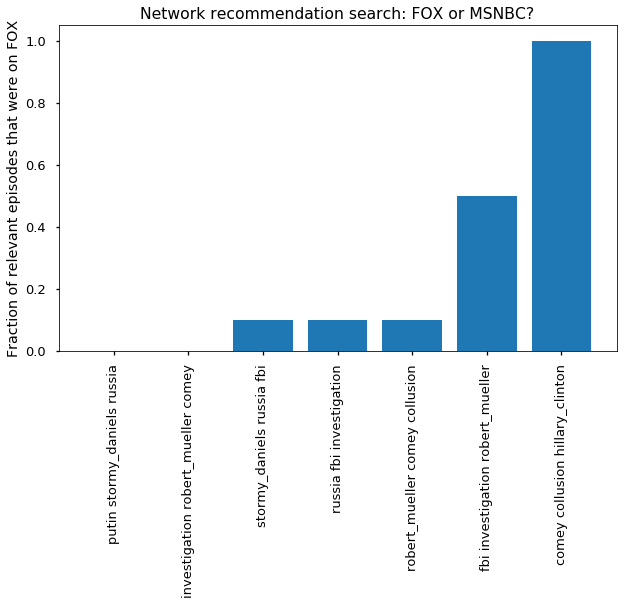

In [10]:
query = "putin stormy_daniels russia fbi investigation robert_mueller comey collusion  hillary_clinton"
percent_fox_list = get_ngram_query_tuples(query, models_dict, doc2network)

search_terms = list(zip(*percent_fox_list))[0]
percent_fox = list(zip(*percent_fox_list))[1]
x_pos = np.arange(len(search_terms)) 

plt.figure(figsize=(10,6))
plt.bar(x_pos, percent_fox,align='center')
plt.xticks(x_pos, search_terms, rotation=90) 
plt.ylabel('Fraction of relevant episodes that were on FOX')

plt.title('Network recommendation search: FOX or MSNBC?')
plt.show()

In [36]:

network = 'combined'
vis = pyLDAvis.gensim.prepare(topic_model = models_dict[network]['model'], 
                              corpus = models_dict[network]['corpus'], 
                              dictionary = models_dict[network]['id2word'])
vis

2018-06-04 15:21:27,206 : DEBUG : performing inference on a chunk of 506 documents
2018-06-04 15:21:28,494 : DEBUG : 45/506 documents converged within 50 iterations
/Users/timcodes/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      36.224339        1       1 -0.030053  0.042060
1      33.460136        1       2 -0.029632 -0.042258
2      30.315525        1       3  0.059685  0.000198, topic_info=      Category         Freq                Term        Total  loglift  logprob
term                                                                          
405    Default  3986.000000                 fbi  3986.000000  30.0000  30.0000
598    Default  1961.000000         james_comey  1961.000000  29.0000  29.0000
2392   Default  1075.000000                memo  1075.000000  28.0000  28.0000
8592   Default  1124.000000           roy_moore  1124.000000  27.0000  27.0000
341    Default  1000.000000             dossier  1000.000000  26.0000  26.0000
947    Default  2786.000000             russian  2786.000000  25.0000  25.0000
6573   Default  1021.000000             alabama  1021.000000  24.0000  24.0000
568    Default  2417.000000         information  2417.000000  23.0000  23.0000
943    Default  2744.000000              russia  2744.000000  22.0000  22.0000
1185   Default  3962.000000         white_house  3962.000000  21.0000  21.0000
519    Default  1560.000000     hillary_clinton  1560.000000  20.0000  20.0000
583    Default  4159.000000       investigation  4159.000000  19.0000  19.0000
697    Default  1833.000000              media_  1833.000000  18.0000  18.0000
155    Default  3403.000000            campaign  3403.000000  17.0000  17.0000
608    Default   572.000000          john_kelly   572.000000  16.0000  16.0000
696    Default   528.000000              mccabe   528.000000  15.0000  15.0000
1190   Default  2225.000000               woman  2225.000000  14.0000  14.0000
907    Default  4730.000000          republican  4730.000000  13.0000  13.0000
174    Default   388.000000  christopher_steele   388.000000  12.0000  12.0000
188    Default  1306.000000             clinton  1306.000000  11.0000  11.0000
1026   Default  1643.000000     special_counsel  1643.000000  10.0000  10.0000
10666  Default   559.000000        steve_bannon   559.000000   9.0000   9.0000
158    Default   339.000000         carter_page   339.000000   8.0000   8.0000
4397   Default   604.000000         immigration   604.000000   7.0000   7.0000
2541   Default   740.000000  special_prosecutor   740.000000   6.0000   6.0000
18461  Default   354.000000              mcgahn   354.000000   5.0000   5.0000
866    Default  2192.000000               quote  2192.000000   4.0000   4.0000
55     Default   401.000000       andrew_mccabe   401.000000   3.0000   3.0000
937    Default   937.000000      rod_rosenstein   937.000000   2.0000   2.0000
373    Default  1340.000000            evidence  1340.000000   1.0000   1.0000
...        ...          ...                 ...          ...      ...      ...
574     Topic3   438.933990        intelligence   675.409973   0.7625  -6.7424
1026    Topic3   863.992188     special_counsel  1643.944092   0.5502  -6.0652
767     Topic3   434.243927                page   676.672119   0.7499  -6.7532
697     Topic3   909.057861              media_  1833.956055   0.4917  -6.0144
155     Topic3  1408.807495            campaign  3403.669922   0.3114  -5.5763
334     Topic3   654.137634            document  1208.729736   0.5795  -6.3435
934     Topic3  1321.180176      robert_mueller  3266.388184   0.2884  -5.6405
750     Topic3   755.089294            official  1526.675049   0.4895  -6.1999
621     Topic3   649.962708  justice_department  1245.370850   0.5432  -6.3499
903     Topic3  1053.104248              report  2579.937500   0.2975  -5.8673
1021    Topic3   497.059601              source   849.498535   0.6576  -6.6181
391     Topic3  1168.721191                fact  3127.296875   0.2093  -5.7631
53      Topic3  1217.757446            american  3387.469727   0.1704  -5.7220
618     Topic3   587.266968               judge  1111

In [37]:
network = 'FOX'
vis = pyLDAvis.gensim.prepare(topic_model = models_dict[network]['model'], 
                              corpus = models_dict[network]['corpus'], 
                              dictionary = models_dict[network]['id2word'])
vis

2018-06-04 15:21:34,893 : DEBUG : performing inference on a chunk of 240 documents
2018-06-04 15:21:35,696 : DEBUG : 36/240 documents converged within 50 iterations
/Users/timcodes/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      43.402107        1       1 -0.060417 -0.018233
0      32.700726        1       2  0.054048 -0.025539
1      23.897163        1       3  0.006368  0.043772, topic_info=     Category         Freq             Term        Total  loglift  logprob
term                                                                      
399   Default  2126.000000              fbi  2126.000000  30.0000  30.0000
590   Default  1249.000000      james_comey  1249.000000  29.0000  29.0000
337   Default   739.000000          dossier   739.000000  28.0000  28.0000
2421  Default   514.000000      north_korea   514.000000  27.0000  27.0000
562   Default  1354.000000      information  1354.000000  26.0000  26.0000
2389  Default   608.000000             memo   608.000000  25.0000  25.0000
576   Default  1750.000000    investigation  1750.000000  24.0000  24.0000
514   Default  1293.000000  hillary_clinton  1293.000000  23.0000  23.0000
932   Default  1243.000000   robert_mueller  1243.000000  22.0000  22.0000
2855  Default   312.000000             iran   312.000000  21.0000  21.0000
693   Default  1523.000000           media_  1523.000000  20.0000  20.0000
185   Default  1037.000000          clinton  1037.000000  19.0000  19.0000
367   Default   753.000000         evidence   753.000000  18.0000  18.0000
4452  Default   201.000000            syria   201.000000  17.0000  17.0000
1951  Default   256.000000     text_message   256.000000  16.0000  16.0000
692   Default   386.000000           mccabe   386.000000  15.0000  15.0000
1927  Default   270.000000           strzok   270.000000  14.0000  14.0000
946   Default   852.000000          russian   852.000000  13.0000  13.0000
656   Default   463.000000              lie   463.000000  12.0000  12.0000
1868  Default   625.000000           school   625.000000  11.0000  11.0000
1548  Default   471.000000              gun   471.000000  10.0000  10.0000
1025  Default   660.000000  special_counsel   660.000000   9.0000   9.0000
1760  Default   297.000000     peter_strzok   297.000000   8.0000   8.0000
2173  Default   863.000000             deal   863.000000   7.0000   7.0000
942   Default   793.000000           russia   793.000000   6.0000   6.0000
4208  Default   436.000000            china   436.000000   5.0000   5.0000
331   Default   597.000000         document   597.000000   4.0000   4.0000
2879  Default   133.000000         kim_jong   133.000000   3.0000   3.0000
1505  Default   250.000000       fisa_court   250.000000   2.0000   2.0000
935   Default   432.000000   rod_rosenstein   432.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
2426   Topic3    70.140823          nuclear   108.648941   0.9938  -7.5687
1144   Topic3   348.173431           united  1063.758545   0.3145  -5.9665
1190   Topic3   361.763031            woman  1131.935303   0.2907  -5.9282
1200   Topic3   253.310425            world   688.287842   0.4318  -6.2846
462    Topic3   459.387939             good  1710.813965   0.1166  -5.6893
252    Topic3   309.967590           course  1038.460205   0.2224  -6.0827
53     Topic3   478.671936         american  2035.944824  -0.0163  -5.6482
958    Topic3   436.048523           saying  1771.517090   0.0296  -5.7415
942    Topic3   258.444427           russia   793.689697   0.3094  -6.2645
32     Topic3   443.591125         actually  1906.365967  -0.0266  -5.7243
222    Topic3   263.649841         congress   853.124207   0.2571  -6.2446
312    Topic3   400.422913            didnt  1706.057373  -0.0180  -5.8267
386    Topic3   387.789886             fact  1656.911987  -0.0208  -5.8587
1185   Topic3   246.263489      white_house   808.473755   0.2427  -6.3128
903    Topic3   258.488129           report   877.918213   0.2087  -6.2644
251    Topic3   415.520477          country  2052.633301  -0.1659  -5.7897
1077   Topic

In [38]:
network = 'MSNBC'
vis = pyLDAvis.gensim.prepare(topic_model = models_dict[network]['model'], 
                              corpus = models_dict[network]['corpus'], 
                              dictionary = models_dict[network]['id2word'])
vis

2018-06-04 15:21:45,135 : DEBUG : performing inference on a chunk of 266 documents
2018-06-04 15:21:45,839 : DEBUG : 27/266 documents converged within 50 iterations
/Users/timcodes/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      41.653336        1       1  0.049164  0.017639
2      39.470806        1       2 -0.006222 -0.044245
1      18.875862        1       3 -0.042942  0.026605, topic_info=      Category         Freq                Term        Total  loglift  logprob
term                                                                          
788    Default  1998.000000            question  1998.000000  30.0000  30.0000
2291   Default   521.000000          john_kelly   521.000000  29.0000  29.0000
1068   Default  3139.000000         white_house  3139.000000  28.0000  28.0000
1972   Default  1044.000000               woman  1044.000000  27.0000  27.0000
605    Default  1220.000000       michael_cohen  1220.000000  26.0000  26.0000
828    Default  2920.000000          republican  2920.000000  25.0000  25.0000
845    Default  1825.000000      robert_mueller  1825.000000  24.0000  24.0000
4452   Default   625.000000  special_prosecutor   625.000000  23.0000  23.0000
949    Default  2050.000000               story  2050.000000  22.0000  22.0000
6643   Default   298.000000          rob_porter   298.000000  21.0000  21.0000
348    Default  1794.000000                 fbi  1794.000000  20.0000  20.0000
2911   Default   295.000000       michael_flynn   295.000000  19.0000  19.0000
851    Default   284.000000       rudy_giuliani   284.000000  18.0000  18.0000
1052   Default  1312.000000                vote  1312.000000  17.0000  17.0000
5338   Default   319.000000              mcgahn   319.000000  16.0000  16.0000
886    Default  1017.000000              senate  1017.000000  15.0000  15.0000
551    Default  1761.000000              lawyer  1761.000000  14.0000  14.0000
11040  Default   769.000000           roy_moore   769.000000  13.0000  13.0000
2284   Default   696.000000         james_comey   696.000000  12.0000  12.0000
2204   Default   581.000000               flynn   581.000000  11.0000  11.0000
871    Default  1816.000000              saying  1816.000000  10.0000  10.0000
535    Default   874.000000  justice_department   874.000000   9.0000   9.0000
4014   Default   458.000000        steve_bannon   458.000000   8.0000   8.0000
5034   Default   302.000000             tax_cut   302.000000   7.0000   7.0000
1073   Default   557.000000             witness   557.000000   6.0000   6.0000
142    Default  2096.000000                case  2096.000000   5.0000   5.0000
2482   Default   361.000000            subpoena   361.000000   4.0000   4.0000
272    Default  1530.000000            democrat  1530.000000   3.0000   3.0000
285    Default  1654.000000               didnt  1654.000000   2.0000   2.0000
512    Default  2401.000000       investigation  2401.000000   1.0000   1.0000
...        ...          ...                 ...          ...      ...      ...
949     Topic3   546.722412               story  2050.205566   0.3455  -5.4262
1073    Topic3   211.858841             witness   557.164490   0.7003  -6.3742
2204    Topic3   216.245026               flynn   581.324829   0.6784  -6.3537
605     Topic3   361.320618       michael_cohen  1220.675781   0.4499  -5.8404
5034    Topic3   134.730042             tax_cut   302.980072   0.8569  -6.8269
4014    Topic3   178.571426        steve_bannon   458.451050   0.7244  -6.5452
828     Topic3   607.790894          republican  2920.147949   0.0977  -5.3203
3613    Topic3   159.451202           testimony   395.918945   0.7578  -6.6584
886     Topic3   296.346436              senate  1017.426025   0.4338  -6.0386
871     Topic3   417.477173              saying  1816.824341   0.1967  -5.6959
11040   Topic3   241.841522           roy_moore   769.465576   0.5099  -6.2419
285     Topic3   382.372528               didnt  1654.970825   0.2021  -5.7838
540     Topic3   417.169006                kind  1945.976562   0.1273  -5.6967
255     Topic3   471.226410                 day  2447